======================================================
# Ames housing prices prediction 
======================================================


<font color=blue>**Importing Libraries and reading the dataset**</font>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import lightgbm as lgb
import warnings
%matplotlib inline
from scipy import stats
from scipy.stats import norm, skew
from subprocess import check_output
from sklearn.preprocessing import LabelEncoder
from scipy.special import boxcox1p
from scipy.stats import boxcox

In [2]:
color= sns.color_palette()
sns.set_style('whitegrid')

In [3]:
train=pd.read_csv(r'C:\Users\aaparajit\Desktop\Nerdville Horror\Py_Predicting_House_Prices_Kaggle_Stacking\train.csv')
test=pd.read_csv(r'C:\Users\aaparajit\Desktop\Nerdville Horror\Py_Predicting_House_Prices_Kaggle_Stacking\test.csv')

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
train.shape

(1460, 81)

In [7]:
test.shape

(1459, 80)

In [8]:
# storing Id separately and dropping it from the data
train_id=train['Id']
test_id=test['Id']

In [9]:
train.drop(columns=(['Id']),axis=1,inplace=True)
test.drop(columns=(['Id']),axis=1,inplace=True)

In [10]:
train.shape

(1460, 80)

In [11]:
test.shape

(1459, 79)

***

<font color=blue>**Outlier detection**</font>

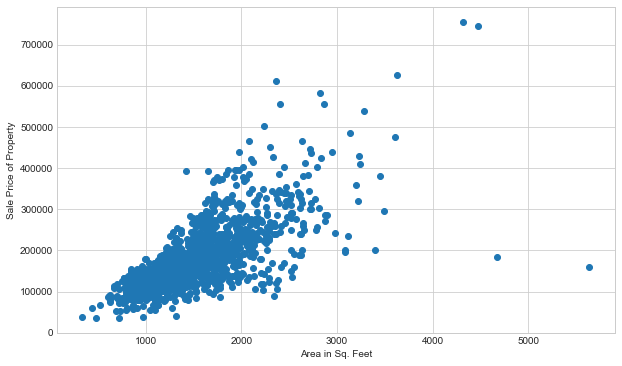

In [12]:
fig, ax= plt.subplots(figsize=(10,6))
ax.scatter(x=train['GrLivArea'],y=train['SalePrice'])
plt.xlabel('Area in Sq. Feet')
plt.ylabel('Sale Price of Property')
plt.show()

In [13]:
# We notice two outliers in the bottom right of the graph
# These two houses were sold cheap despite a huge area 
# we can drop them 

In [14]:
train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index

Int64Index([523, 1298], dtype='int64')

In [15]:
train=train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

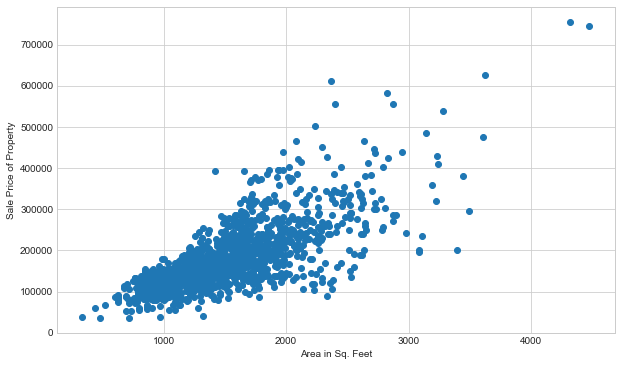

In [16]:
# validating that the two outliers have been removed
fig, ax= plt.subplots(figsize=(10,6))
ax.scatter(x=train['GrLivArea'],y=train['SalePrice'])
plt.xlabel('Area in Sq. Feet')
plt.ylabel('Sale Price of Property')
plt.show()

C:\Users\aaparajit\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


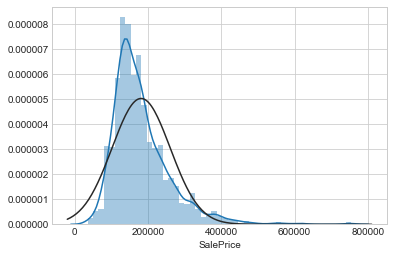

In [17]:
sns.distplot(train['SalePrice'],fit=norm)

In [18]:
(mu,sigma)=norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))


 mu = 180932.92 and sigma = 79467.79



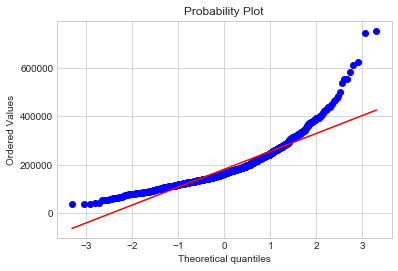

In [19]:
# let us also check the qq plot 
fig=plt.figure()
res=stats.probplot(train['SalePrice'],plot=plt)
plt.show()

In [20]:
# the target varible is not normally distributed and will need to be transformed

***

<font color=blue>**Log -transformation of SalePrice**</font>

In [21]:
train['SalePrice']=np.log1p(train['SalePrice'])

C:\Users\aaparajit\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


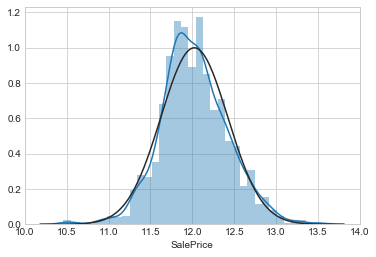

In [22]:
# checking distribution again
sns.distplot(train['SalePrice'],fit=norm)

In [23]:
(mu,sigma)=norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))


 mu = 12.02 and sigma = 0.40



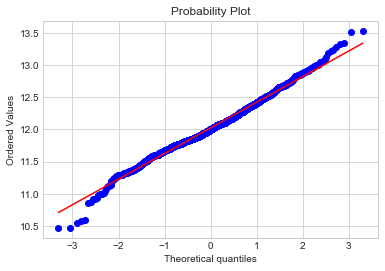

In [24]:
fig=plt.figure()
res=stats.probplot(train['SalePrice'],plot=plt)
plt.show()

In [25]:
# The dependent variable now mimics normal distribution

In [26]:
ntrain=train.shape[0]
ntest=test.shape[0]

In [27]:
y_train=train.SalePrice.values

In [28]:
data=pd.concat((train,test),sort=True).reset_index(drop=True)

In [29]:
data.drop(['SalePrice'],axis=1,inplace=True)

In [30]:
data.shape

(2917, 79)

***

<font color=blue>**Checking for missing data**</font>

In [31]:
na_data=(data.isnull().sum()/len(data))*100

In [32]:
na_data=na_data.drop(na_data[na_data==0].index).sort_values(ascending=False)

In [33]:
na_data

PoolQC          99.691464
MiscFeature     96.400411
Alley           93.212204
Fence           80.425094
FireplaceQu     48.680151
LotFrontage     16.660953
GarageQual       5.450806
GarageCond       5.450806
GarageFinish     5.450806
GarageYrBlt      5.450806
GarageType       5.382242
BsmtExposure     2.811107
BsmtCond         2.811107
BsmtQual         2.776826
BsmtFinType2     2.742544
BsmtFinType1     2.708262
MasVnrType       0.822763
MasVnrArea       0.788481
MSZoning         0.137127
BsmtFullBath     0.068564
BsmtHalfBath     0.068564
Utilities        0.068564
Functional       0.068564
Electrical       0.034282
BsmtUnfSF        0.034282
Exterior1st      0.034282
Exterior2nd      0.034282
TotalBsmtSF      0.034282
GarageArea       0.034282
GarageCars       0.034282
BsmtFinSF2       0.034282
BsmtFinSF1       0.034282
KitchenQual      0.034282
SaleType         0.034282
dtype: float64

In [34]:
missing_data=pd.DataFrame({'Missing Percent':na_data})

In [35]:
missing_data

,Missing Percent
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageQual,5.450806
GarageCond,5.450806
GarageFinish,5.450806
GarageYrBlt,5.450806


Text(0,0.5,'Percentage of missing data')

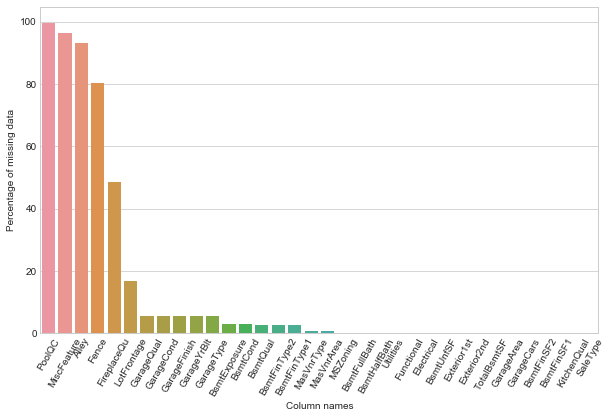

In [36]:
fig, ax= plt.subplots(figsize=(10,6))
plt.xticks(rotation='60')
sns.barplot(x=na_data.index,y=na_data)
plt.xlabel('Column names')
plt.ylabel('Percentage of missing data')

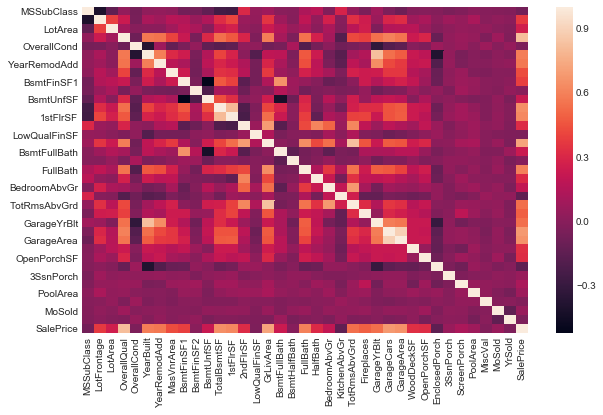

In [37]:
fig, ax= plt.subplots(figsize=(10,6))
sns.heatmap(train.corr())

***

<font color=blue>**Imputing missing data on a case by case basis**</font>

In [38]:
# poolQC= if the house has a pool. the metadata mentions NA = No pool
data['PoolQC']=data['PoolQC'].fillna('None')
# Miscfeature= metadata says NA means no misc features
data['MiscFeature']=data['MiscFeature'].fillna('None')
# Alley= metadata mentions NA means no alley access
data['Alley']=data['Alley'].fillna('None')
# fence= NA means no fence
data['Fence']=data['Fence'].fillna('None')
# FireplaceQu= NA means no fireplace
data['FireplaceQu']=data['FireplaceQu'].fillna('None')

In [39]:
# Lotfrontage = assuming that the frontage area of most houses will be similar in similar neighbourhoods
data['LotFrontage']=data.groupby('Neighborhood')['LotFrontage'].transform(lambda x:x.fillna(x.median()))

In [40]:
# garagetype, garagefinish, garageQua1 and GarageCond
for i in ('GarageType','GarageFinish','GarageQual','GarageCond'):
    data[i]=data[i].fillna('None')

In [41]:
# GarageYrBlt,GarageArea, GarageCars replacing missing values with zero
for i in ('GarageYrBlt','GarageArea','GarageCars'):
    data[i]=data[i].fillna(0)

In [42]:
# BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath 
# missing values replaced with zero incase on no basement
for i in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath','BsmtHalfBath'):
    data[i]=data[i].fillna(0)

In [43]:
# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2
# these are categorical - NA means no basement
for i in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1','BsmtFinType2'):
    data[i]=data[i].fillna('None')

In [44]:
# MasVnrArea and MasVnrType
data["MasVnrType"] = data["MasVnrType"].fillna("None")
data["MasVnrArea"] = data["MasVnrArea"].fillna(0)

In [45]:
# checking counts for MSZoning
data.MSZoning.value_counts()

RL         2263
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

In [46]:
data['MSZoning']=data['MSZoning'].fillna(data['MSZoning'].mode()[0])

In [47]:
data['Utilities'].value_counts()

AllPub    2914
NoSeWa       1
Name: Utilities, dtype: int64

In [48]:
# Utilities is a gegenrate variable so can be safely excluded 
data.drop(['Utilities'],axis=1,inplace=True)

In [49]:
# functional = metadata mentions that na means typical
data['Functional']=data['Functional'].fillna('Typical')

In [50]:
data['Electrical'].value_counts()

SBrkr    2669
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [51]:
# filling NA values for electrical with the SBrkr
data['Electrical']=data['Electrical'].fillna(data['Electrical'].mode()[0])

In [52]:
data['KitchenQual'].value_counts()

TA    1492
Gd    1151
Ex     203
Fa      70
Name: KitchenQual, dtype: int64

In [53]:
# KitchenQual has only one null value so we can safely replace it with the mode
data['KitchenQual'].isnull().sum(axis=0)

1

In [54]:
data['KitchenQual']=data['KitchenQual'].fillna(data['KitchenQual'].mode()[0])

In [55]:
# Exterior1st and Exterior2nd
data['Exterior1st'].isnull().sum(axis=0)

1

In [56]:
data['Exterior2nd'].isnull().sum(axis=0)

1

In [57]:
# using the same methodology of replacing with the mode
data['Exterior1st']=data['Exterior1st'].fillna(data['Exterior1st'].mode()[0])
data['Exterior2nd']=data['Exterior2nd'].fillna(data['Exterior2nd'].mode()[0])

In [58]:
# SaleType
data['SaleType'].value_counts()

WD       2525
New       237
COD        87
ConLD      26
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
Name: SaleType, dtype: int64

In [59]:
data['SaleType'].isnull().sum(axis=0)

1

In [60]:
data['SaleType']=data['SaleType'].fillna(data['SaleType'].mode()[0])

In [61]:
# MSSubClass replacing NA values with None
data['MSSubClass']=data['MSSubClass'].fillna("None")

In [62]:
data.isnull().values.any()

False

***

<font color=blue>**Transforming variables - Those numerical variables that are actually categorical**</font>

In [63]:
# MSSubClass, OverallCond , YrSold, MoSold
# All these variables are actually categorical so they should be converted to strings
data['MSSubClass'].value_counts()

20     1079
60      573
50      287
120     182
30      139
160     128
70      128
80      118
90      109
190      61
85       48
75       23
45       18
180      17
40        6
150       1
Name: MSSubClass, dtype: int64

In [64]:
data['OverallCond'].value_counts()

5    1643
6     531
7     390
8     144
4     101
3      50
9      41
2      10
1       7
Name: OverallCond, dtype: int64

In [65]:
data['YrSold'].value_counts()

2007    691
2009    647
2008    621
2006    619
2010    339
Name: YrSold, dtype: int64

In [66]:
data['MoSold'].value_counts()

6     503
7     446
5     394
4     279
8     233
3     232
10    172
9     158
11    142
2     133
1     121
12    104
Name: MoSold, dtype: int64

In [67]:
data['MSSubClass']=data['MSSubClass'].apply(str)
data['OverallCond']=data['OverallCond'].astype(str)
data['YrSold']=data['YrSold'].astype(str)
data['MoSold']=data['MoSold'].astype(str)

In [68]:
cols = ('FireplaceQu','BsmtCond', 'GarageQual', 'GarageCond','BsmtQual', 
        'ExterQual', 'ExterCond', 'PoolQC', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
for i in cols:
    lbl=LabelEncoder()
    lbl.fit(list(data[i].values))
    data[i]=lbl.transform(list(data[i].values))

In [69]:
data.shape

(2917, 78)

In [70]:
# YearBuilt YearRemodAdd are also categorical with many values so dropping them
data.drop(columns=(['YearBuilt','YearRemodAdd']),axis=1,inplace=True)

***


<font color=blue>**Dealing with ordinal variables**</font>

In [71]:
# 'KitchenQual''HeatingQC' are ordinal variables so one hot encoding is not ideal for them
data['KitchenQual'].value_counts()

TA    1493
Gd    1151
Ex     203
Fa      70
Name: KitchenQual, dtype: int64

In [72]:
map1 = {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0} 
data['KitchenQual'] = data['KitchenQual'].map(map1)

In [73]:
data['HeatingQC'].value_counts()

Ex    1491
TA     857
Gd     474
Fa      92
Po       3
Name: HeatingQC, dtype: int64

In [74]:
data['HeatingQC'] = data['HeatingQC'].map(map1)

***

<font color=blue>**Checking and correcting for skewness**</font>

In [75]:
numeric_variables=data.dtypes[data.dtypes!=object].index

In [76]:
skew=data[numeric_variables].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

In [77]:
skew.head()

MiscVal         21.939672
PoolArea        17.688664
LotArea         13.109495
LowQualFinSF    12.084539
3SsnPorch       11.372080
dtype: float64

In [78]:
skewness=pd.DataFrame({'Skew':skew})

In [79]:
skewness.head()

,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080


***

<font color=blue>**Finding the optimal transformation using Box-Cox**</font>

In [80]:
skewness=skewness[abs(skewness)>0.75]

In [81]:
skewness.dropna(axis=0,inplace=True)

In [82]:
skewed_features=skew.index
lam=0.15
for i in skewed_features:
    data[i]=boxcox1p(data[i],lam)

***

<font color=blue>**Creating dummy variables**</font>

In [83]:
data.shape

(2917, 76)

In [84]:
data=pd.get_dummies(data=data,drop_first=True,prefix='Dummy',prefix_sep='_')

In [85]:
data.shape

(2917, 197)

***

<font color=blue>**Creating train test split**</font>

In [86]:
train=data[:ntrain]
test=data[ntrain:]

***

<font color=blue>**Libraries import for data modeling**</font>

In [87]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

***

<font color=blue>**Five fold cross-validation**</font>

In [101]:
folds=5
def rmsle_cv(model):
    kf=KFold(folds,shuffle=True,random_state=42).get_n_splits(train.values)
    rmse=np.sqrt(-cross_val_score(model,train.values,y_train,scoring="neg_mean_squared_error",cv=kf))
    return(rmse)

***

<font color=blue>**Setting base models**</font>

In [91]:
#LASSO
lasso=make_pipeline(RobustScaler(),Lasso(alpha=0.0005,random_state=42))

In [92]:
#Elasticnet
ENet=make_pipeline(RobustScaler(),ElasticNet(alpha=0.0005,l1_ratio=0.9,random_state=101))

In [93]:
#Kernel Ridge Regression
KRR=KernelRidge(alpha=0.6,degree=2,kernel='polynomial',coef0=2.5)

In [94]:
#Gradient bossting with Huber function
GBoost=GradientBoostingRegressor(n_estimators=3000,learning_rate=0.05,max_depth=4,max_features='sqrt',
                                 min_samples_leaf=15,min_samples_split=10,loss='huber',random_state=5)

In [95]:
#XGboost
model_xgb=xgb.XGBRegressor(colsample_bytree=0.46,gamma=0.468,
                          learning_rate=0.05,max_depth=3,min_child_weight=1.787,n_estimators=2200,
                          reg_alpha=0.4640,reg_lambda=0.8571,subsample=0.5320,silent=1,
                          random_state=7,nthread=-1)

In [96]:
#LightGBM
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

***

<font color=blue>**Scoring baseline models**</font>

In [103]:
score=rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1180 (0.0059)



In [104]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1180 (0.0060)



In [105]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1206 (0.0070)



In [106]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1171 (0.0066)



In [107]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1378 (0.0064)



In [108]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1158 (0.0074)



***

<font color=blue>**Scoring baseline models**</font>

In [109]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    # predictions for cloned models 
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [119]:
averaged_models=AveragingModels(models=(lasso,ENet,KRR,GBoost,model_xgb,model_lgb))

In [120]:
score=rmsle_cv(averaged_models)

In [121]:
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1125 (0.0063)



***

<font color=blue>**Creating a meta model**</font>

In [115]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Train the cloned  meta-model using the out-of-fold predictions
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    # Predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [122]:
stacked_average_models=StackingAveragedModels(base_models=(ENet,KRR,GBoost,model_xgb,model_lgb),meta_model=lasso)

In [124]:
score = rmsle_cv(stacked_average_models)
print("Stacked Average models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacked Average models score: 0.1117 (0.0061)


In [125]:
# defining rmsle evaluation function
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [126]:
stacked_average_models.fit(train.values,y_train)

StackingAveragedModels(base_models=(Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('elasticnet', ElasticNet(alpha=0.0005, copy_X=True, fit_intercept=True, l1_ratio=0.9,
      max_iter=1000, normalize=False, positive=...0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)),
            meta_model=Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('lasso', Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=42,
   selection='cyclic', tol=0.0001, warm_start=False))]),
            n_folds=5)

In [127]:
stacked_train_pred=stacked_average_models.predict(train.values)
stacked_pred=np.expm1(stacked_average_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.07670771846904824


<font color=blue>**END!**</font>